# **Dive in Learning**

# ***Diplomado en Computación y Programación Cuántica***

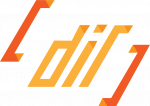

In [ ]:
!pip install qiskit --quiet
!pip install qiskit[visualization] --quiet
!pip install qiskit-aer --quiet
!pip install qiskit-ibm-runtime --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 88.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 118.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.8/366.8 kB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 13.7 MB/s eta 0:00:00


In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService

## **Algoritmo de Deutsch-Jozsa**

- **Caso balanceado**

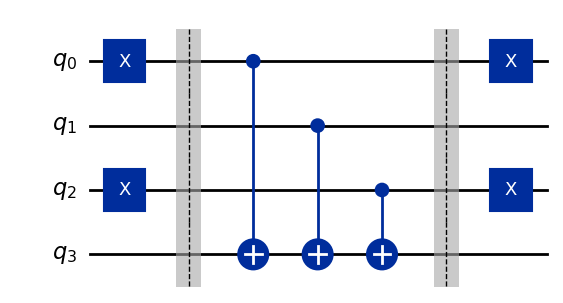

In [ ]:
n=3

balanced_oracle = QuantumCircuit(n+1)
b_str = "101"

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

# Use barrier as divider
balanced_oracle.barrier()

# Controlled-NOT gates
for qubit in range(n):
    balanced_oracle.cx(qubit, n)

balanced_oracle.barrier()

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

# Show oracle
balanced_oracle.draw('mpl')

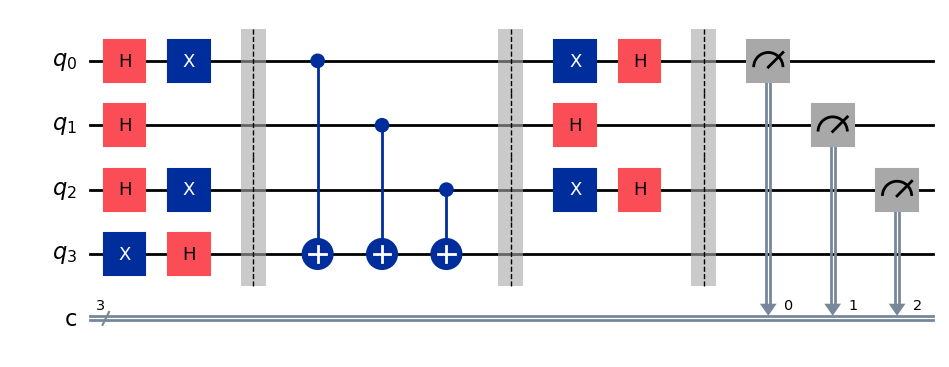

In [ ]:
dj_circuit = QuantumCircuit(n+1,n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.h(n)

# Add oracle
dj_circuit = dj_circuit.compose(balanced_oracle)

# Repeat H-gates
for qubit in range(n):
    dj_circuit.h(qubit)
dj_circuit.barrier()

# Measure
for i in range(n):
     dj_circuit.measure(i, i)

# Display circuit
dj_circuit.draw('mpl')

- **Caso constante**

In [ ]:
def deutsch_jozsa_constant_oracle(n, c):
    """
    Devuelve un circuito cuántico que implementa un oráculo constante para el algoritmo Deutsch-Jozsa.

    Parámetros:
        n (int): Número de qubits en el registro de entrada (no incluye el auxiliar).
        c (int): Valor constante de la función, debe ser 0 o 1.

    Retorna:
        QuantumCircuit: El circuito del oráculo.
    """
    oracle = QuantumCircuit(n + 1)  # n qubits de entrada + 1 qubit auxiliar

    if c == 1:
        # Aplicamos X al qubit auxiliar si f(x) = 1
        oracle.x(n)  # El qubit auxiliar es el último

    return oracle

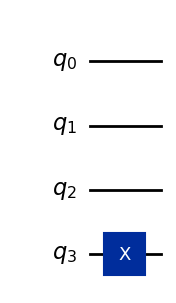

In [ ]:
constante = 1  # f(x) = 1 para todo x

oracle_const = deutsch_jozsa_constant_oracle(n, constante)
oracle_const.draw('mpl')

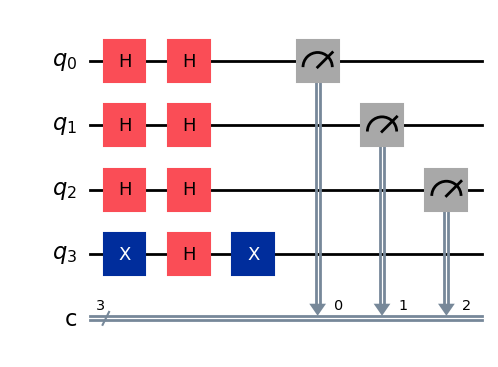

In [ ]:
# Crear el circuito Deutsch-Jozsa
djc_circuit = QuantumCircuit(n+1, n)

# Aplicar Hadamard a los qubits de entrada
for qubit in range(n):
    djc_circuit.h(qubit)

# Poner el último qubit en estado |-> (X seguido de H)
djc_circuit.x(n)
djc_circuit.h(n)


# Agregar el oráculo constante
djc_circuit.compose(oracle_const, inplace=True)

# Aplicar Hadamard a los qubits de entrada nuevamente
for qubit in range(n):
    djc_circuit.h(qubit)

# Medir los n primeros qubits
for i in range(n):
    djc_circuit.measure(i, i)

# Dibujar el circuito
djc_circuit.draw('mpl')

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_cloud", token="E", instance="")
backend = service.backend('')
print(backend)

<IBMBackend('ibm_torino')>


In [ ]:
backends = service.backends(operational=True, min_num_qubits=10)
for backend in backends:
    print(backend.name, backend.status().pending_jobs)

ibm_torino 176
ibm_brisbane 1980


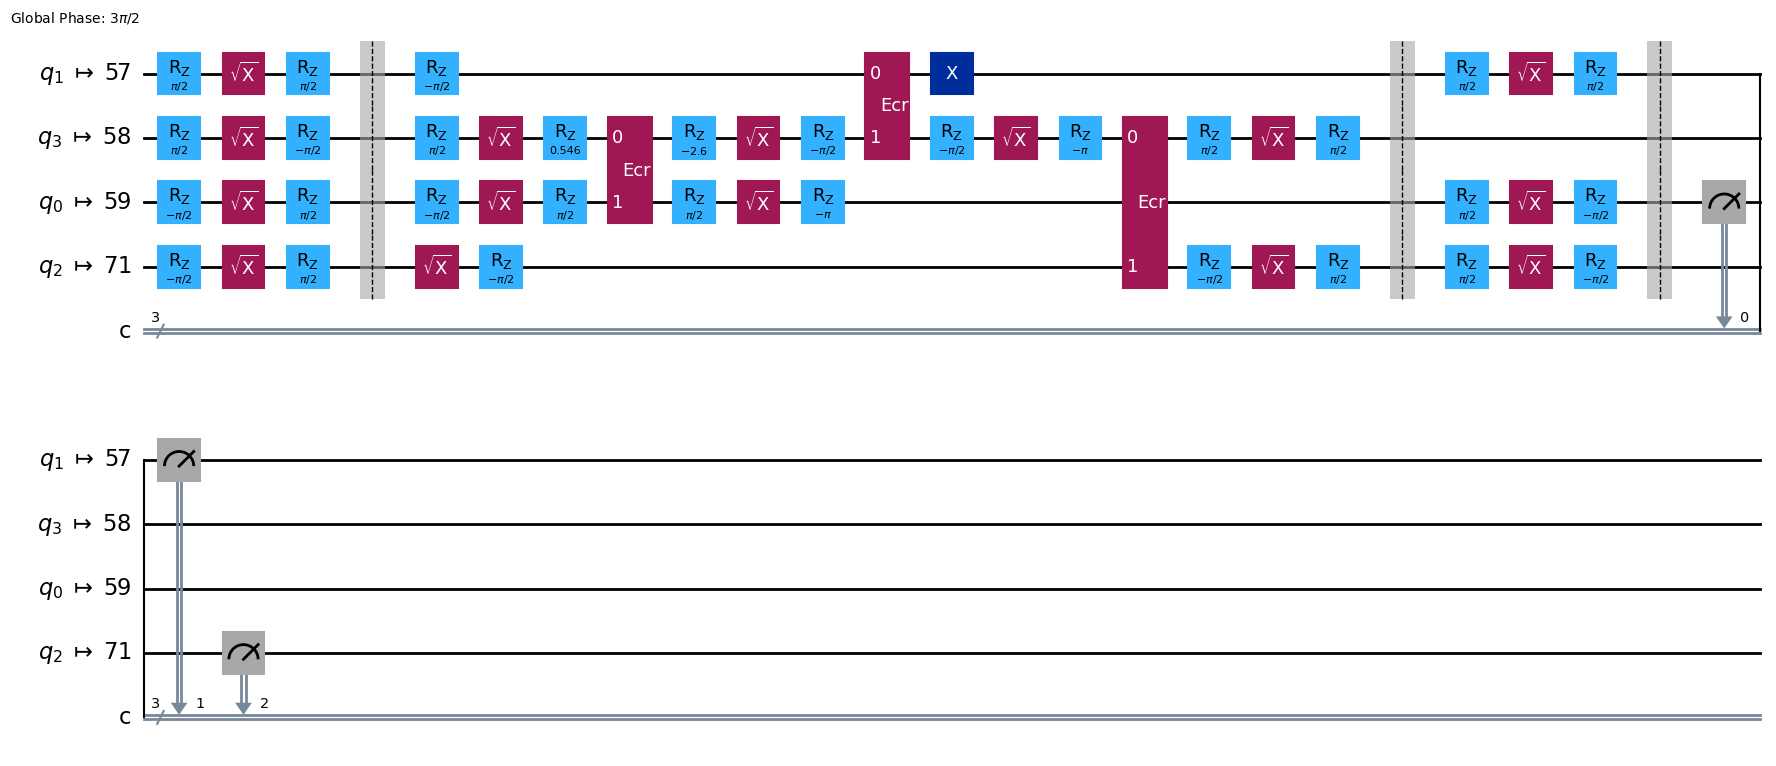

In [ ]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler

pm = generate_preset_pass_manager(optimization_level=3, backend=backend, translation_method='translator')

isa_circuit = pm.run(dj_circuit)

isa_circuit.draw("mpl", idle_wires=False)

In [ ]:
import matplotlib.pyplot as plt

# 1. Crear Sampler para el backend real
sampler = Sampler(mode=backend)

# 2. Ejecutar el circuito optimizado
job = sampler.run([isa_circuit], shots=8192)
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

# 3. Obtener resultados
pub_result = job.result()
print("Resultados crudos:", pub_result)

# 4. Extraer las distribuciones de medición
counts = pub_result[0].data.c.get_counts()

# 5. Graficar histograma
plot_histogram(counts, title="Resultados Deutsch–Jozsa en una computadora cuántica real")